# CAMELYON

## Pre-processing

In [1]:
from pathlib import Path
tumor_001_image = Path("/home/user/CAMELYON16/images/tumor_001.tif")
tumor_001_annotation = Path("/home/user/CAMELYON16/annotations/tumor_001.xml")
tumor_001_mask = Path("/home/user/CAMELYON16/masks/tumor_001_mask.tif")

In [2]:
from wholeslidedata.annotation.parser import MaskAnnotationParser
from wholeslidedata.image.wholeslideimage import WholeSlideImage
from wholeslidedata.annotation.wholeslideannotation import WholeSlideAnnotation
from wholeslidedata.interoperability.asap.parser import AsapAnnotationParser
from wholeslidedata.interoperability.asap.backend import AsapWholeSlideImageBackend
from wholeslidedata.annotation.callbacks import TiledAnnotationCallback
from wholeslidedata.visualization.plotting import plot_annotations
from wholeslidedata.interoperability.asap.annotationwriter import write_asap_annotation
from wholeslidedata.annotation.selector import sort_by_label_value
from matplotlib import pyplot as plt
from colour import Color
import numpy as np
import cv2
from wholeslidedata.visualization.plotting import plot_batch


def is_in_color(patch):
    # filter color
    # Convert the input image to the HSV color space
    hsv = cv2.cvtColor(patch, cv2.COLOR_RGB2HSV)

    lower_bound = np.array([120,20,20])
    upper_bound = np.array([310,255,255])

    # Filter the image to select colors that look like red, pink, or purple
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # Apply the mask to the input image
    colored_image = cv2.bitwise_and(patch, patch, mask=mask)
    if np.count_nonzero(colored_image) > (patch.shape[0] *patch.shape[1])//2:
        return True
    return False

def filter_tissue_tiles(wsa_tumor, wsa_tissue, output_folder):
    annotations = []
    annotations.extend(wsa_tumor.annotations)
    mask_filterd_annotations = []
    for annotation in wsa_tissue.annotations:
        p = tumor_001_wsi.get_region_from_annotations([annotation], spacing=4.0, masked=False)
        if is_in_color(p):
            mask_filterd_annotations.append(annotation)
            annotations.append(annotation)
    output_folder = Path(output_folder)
    output_folder.mkdir(exist_ok=True, parents=True)
    output_path = Path(output_folder) / (wsa_tumor.path.stem + "_tissue.xml")
    write_asap_annotation(annotations, output_path)


In [3]:
tumor_001_wsi = WholeSlideImage(tumor_001_image, backend=AsapWholeSlideImageBackend)
slide_80 = tumor_001_wsi.get_slide(8.0)

tumor_001_tissue = WholeSlideImage(tumor_001_mask, backend=AsapWholeSlideImageBackend)
tissue_80 = tumor_001_tissue.get_slide(8.0)

wsa_tumor = WholeSlideAnnotation(tumor_001_annotation, labels={'tumor': 2})
wsa_tissue = WholeSlideAnnotation(tumor_001_mask, labels={'tissue':1}, parser=MaskAnnotationParser(output_spacing=0.25, processing_spacing=8.0, shape=(2048, 2048)))

In [4]:

color_map={'tumor': Color('red').hex_l, 'tissue': Color('blue').hex_l}

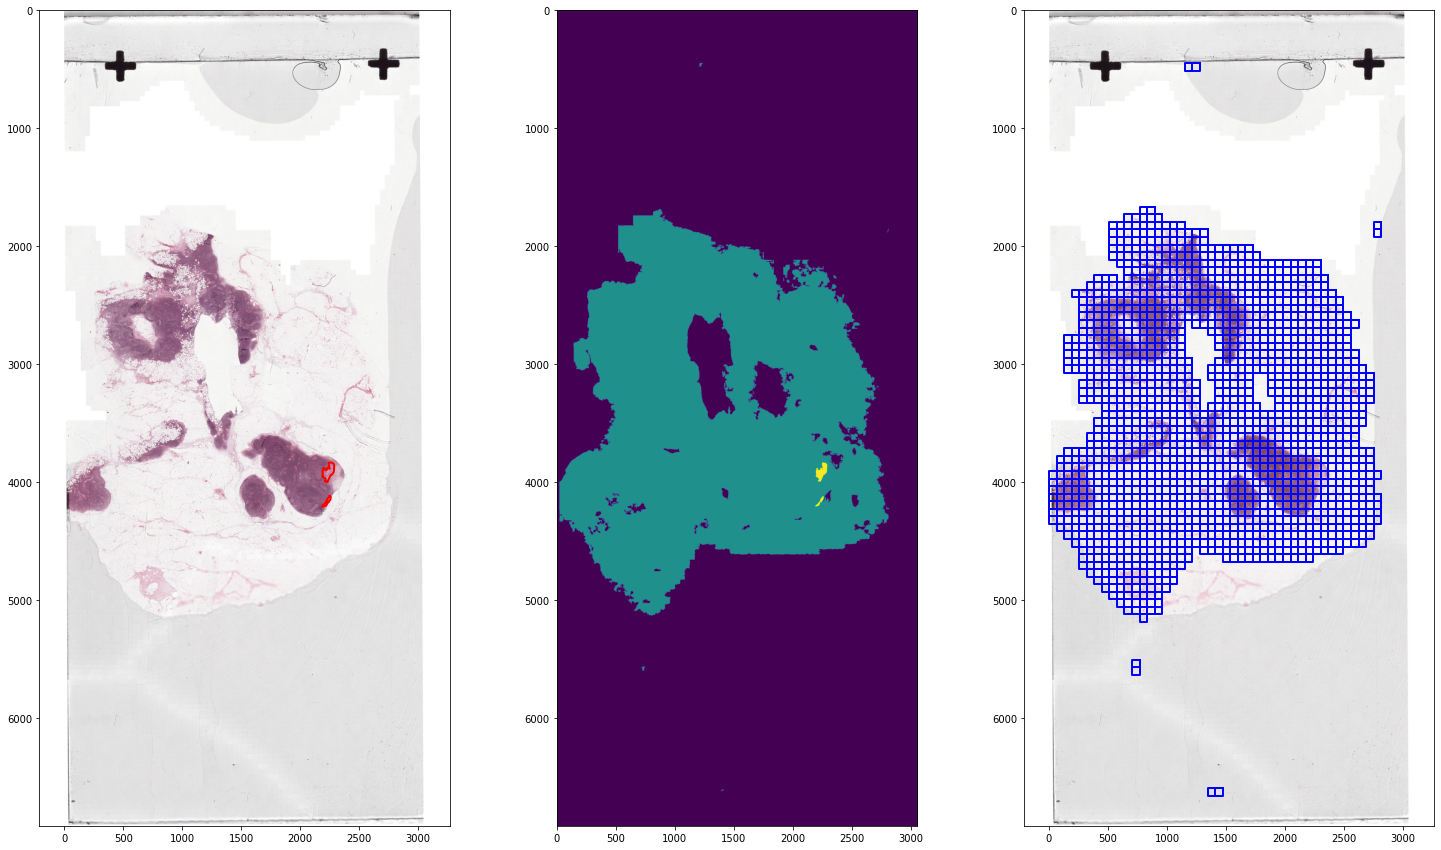

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(25,15))
ax[0].imshow(slide_80)
ax[1].imshow(tissue_80)
ax[2].imshow(slide_80)
plot_annotations(sort_by_label_value(wsa_tumor.annotations), scale=1/32, ax=ax[0], color_map=color_map)
plot_annotations(sort_by_label_value(wsa_tissue.annotations), scale=1/32, ax=ax[2], color_map=color_map)
ax[0].invert_yaxis()
ax[2].invert_yaxis()
plt.show()

In [6]:
filter_tissue_tiles(wsa_tumor, wsa_tissue, output_folder=Path('/home/user/camelyon_annotations/'))

In [7]:
wsa_tissue_filtered = WholeSlideAnnotation("/home/user/camelyon_annotations/tumor_001_tissue.xml")

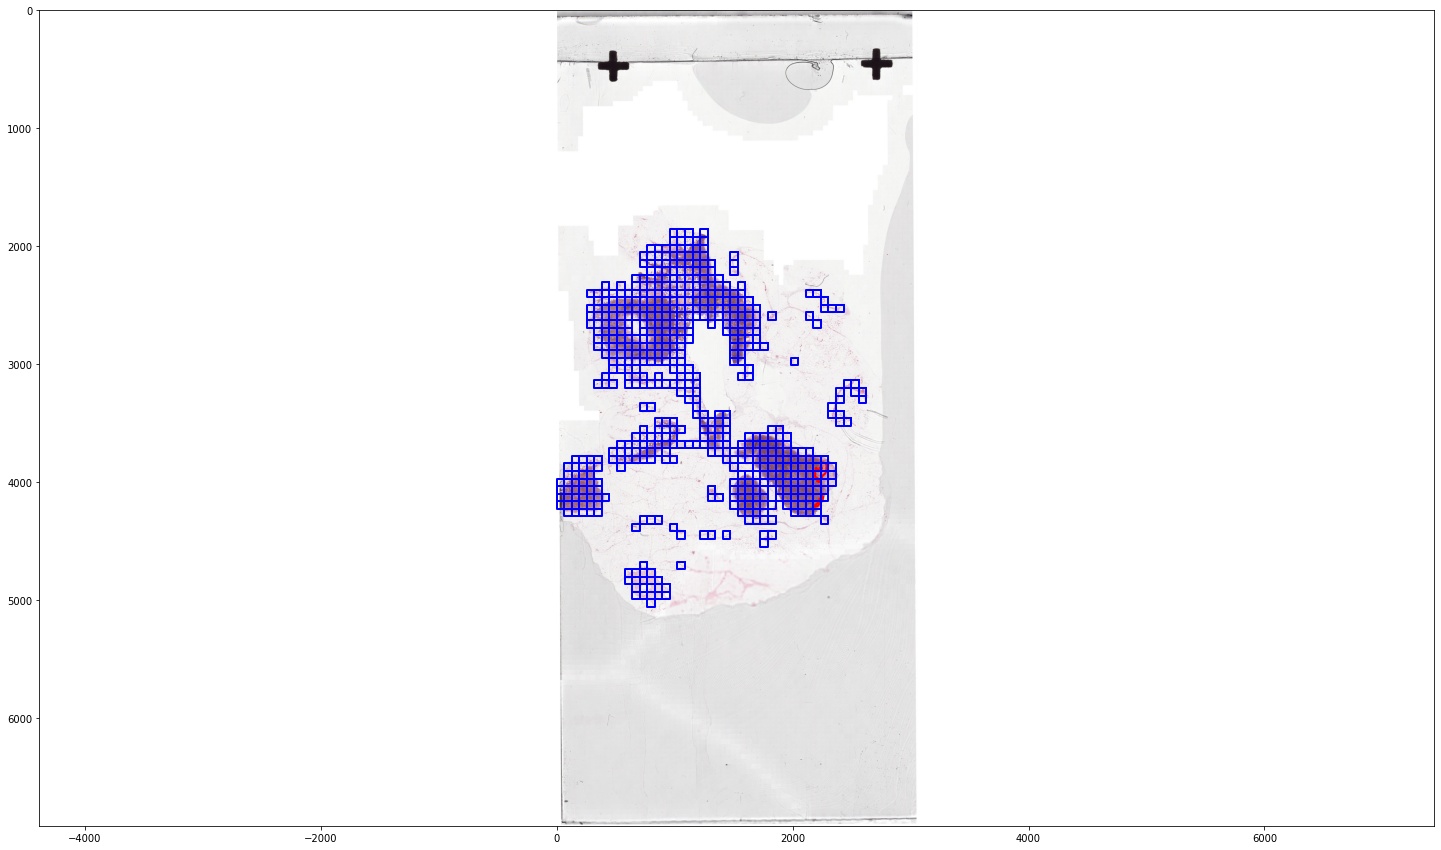

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(25,15))
ax.imshow(slide_80)
plot_annotations(sort_by_label_value(wsa_tissue_filtered.annotations), scale=1/32, ax=ax, color_map=color_map)
ax.invert_yaxis()
plt.show()

In [9]:
# run for subset

## Batch generation

In [2]:
from wholeslidedata.iterators import create_batch_iterator
from wholeslidedata.visualization.plotting import plot_batch, plot_one_hot_batch
from colour import Color

In [13]:
user_config = {
    'wholeslidedata': {
        'default': {
            'yaml_source': {
                'training': [
                    {
                        'wsi': {
                            'path': '/home/user/CAMELYON16/images/tumor_001.tif'
                        },
                        'wsa': {
                            'path': '/home/user/camelyon_annotations/tumor_001_tissue.xml'
                        }
                }
                    
                ]
            },
            'labels': {
                'tissue': 0,
                'tumor': 1,
            },
            'batch_shape': {
                'batch_size': 4,
                'spacing': 4.0,
                'shape': [512, 512, 3]
            }
            
        }
    }
}
mode = "training"

First batch


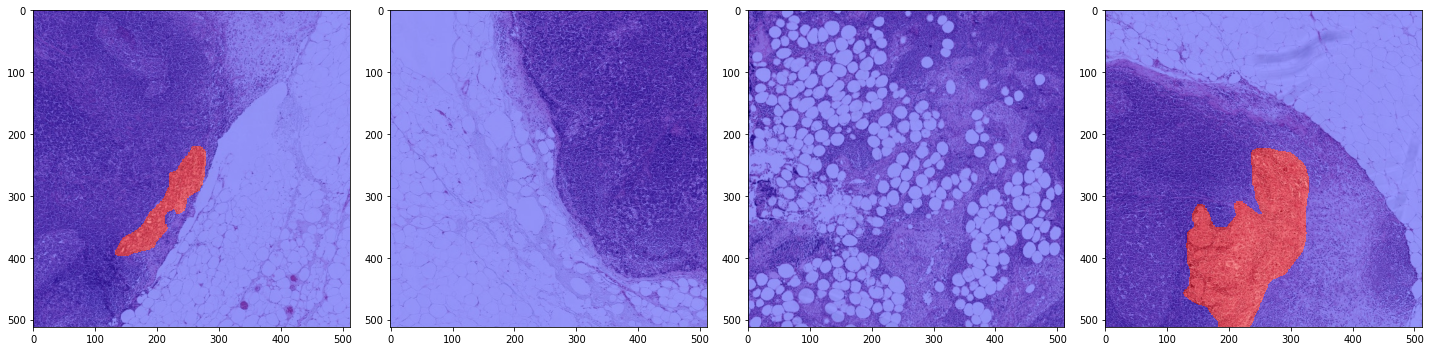

Second batch


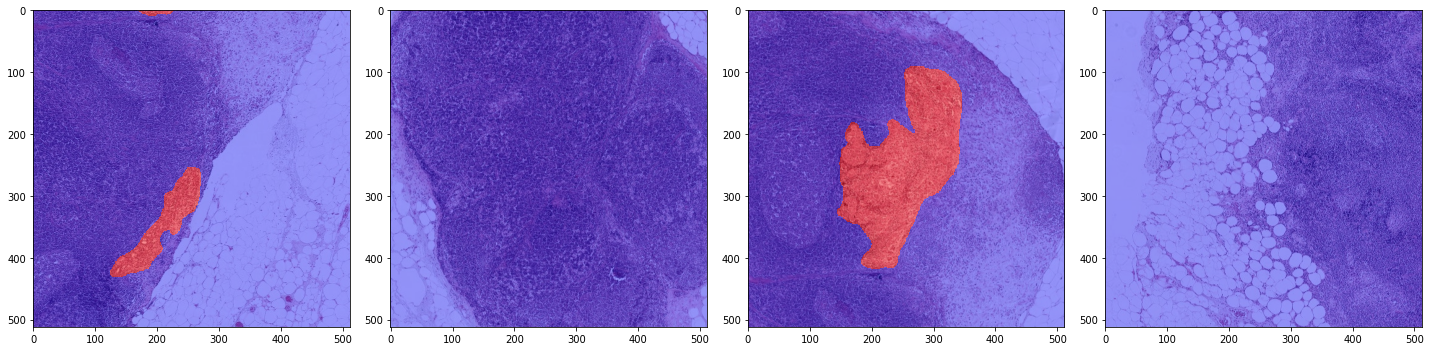

In [16]:


with create_batch_iterator(user_config=user_config,
                            mode=mode) as training_batch_generator:
    
    print('First batch')
    x_batch, y_batch, info =  next(training_batch_generator)
    plot_batch(x_batch, y_batch, alpha=0.4, color_values=['blue', 'red'])
    print('Second batch')
    x_batch, y_batch, info =  next(training_batch_generator)
    plot_batch(x_batch, y_batch, alpha=0.4, color_values=['blue', 'red'])

## One-hot-encoding

In [3]:
user_config = {
    'wholeslidedata': {
        'default': {
            'yaml_source': {
                'training': [
                    {
                        'wsi': {
                            'path': '/home/user/CAMELYON16/images/tumor_001.tif'
                        },
                        'wsa': {
                            'path': '/home/user/camelyon_annotations/tumor_001_tissue.xml'
                        }
                    }
                ]
            },
            'labels': {
                'tissue': 0,
                'tumor': 1,
            },
            'batch_shape': {
                'batch_size': 4,
                'spacing': 4.0,
                'shape': [512, 512, 3],
                 
                # add y_shape to indicate one-hot-encoding, we set the last channel to 2, because we have two classes: tissue and tumor
                'y_shape': [512,512, 2],  
            },
            # Various sample callbacks can be set. Here we add the One-hot-encoding sample callback, which turns the y_batch into a one-hot-encoded representation
            "sample_callbacks": [
                {
                    '*object': "wholeslidedata.samplers.callbacks.OneHotEncodingSampleCallback",
                    
                    # This sample callbacks needs access to the label that can occur in the masks, we can retreive the possible via dataset._labels 
                    'labels': "${dataset.labels}",
                    
                    # Normally (and default setting) you would set this to True and ignore pixels that are not annotated.
                    # However because we can assume than anything that is not annotated is tissue, we can set this to False.
                    # This makes sure that all the y_patches have a corresponding labels for each pixel in the input patch
                    'ignore_zero': False,  
                }
            ] 
        }
    }
}
mode = "training"

First batch


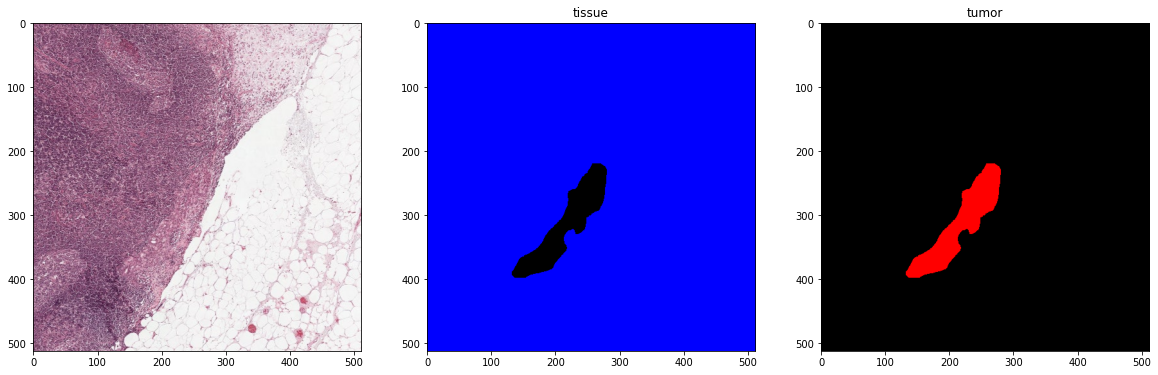

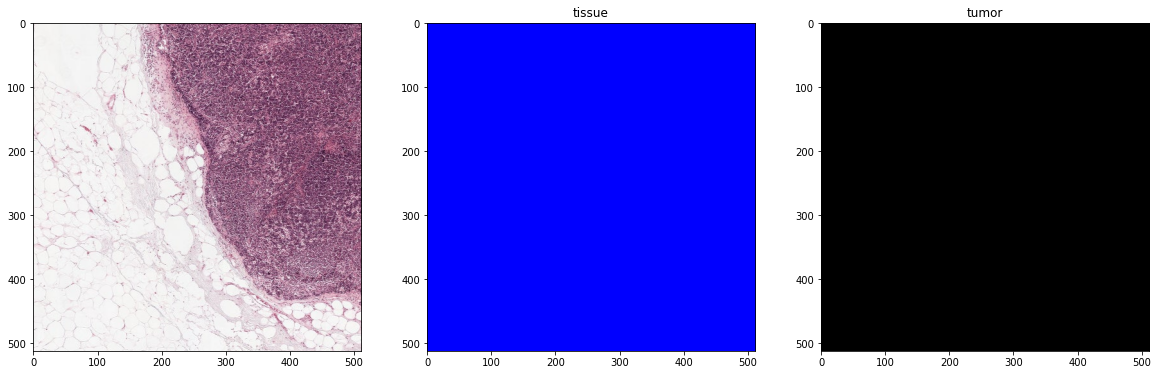

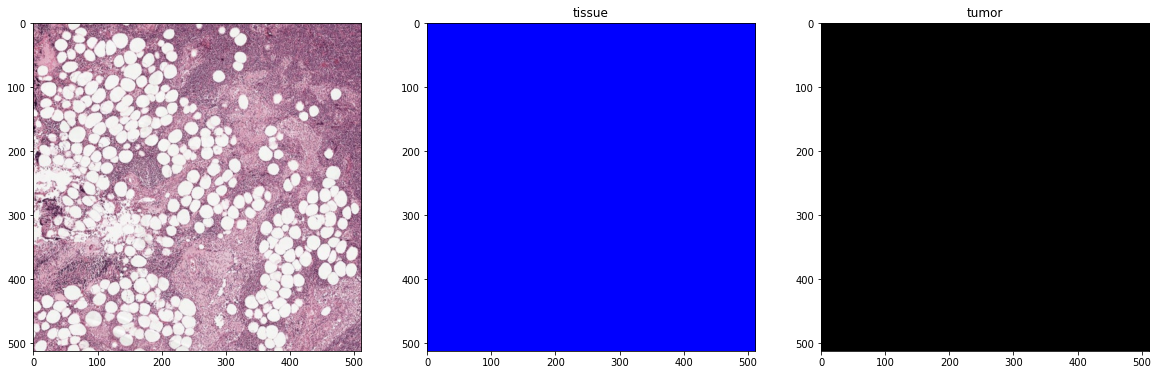

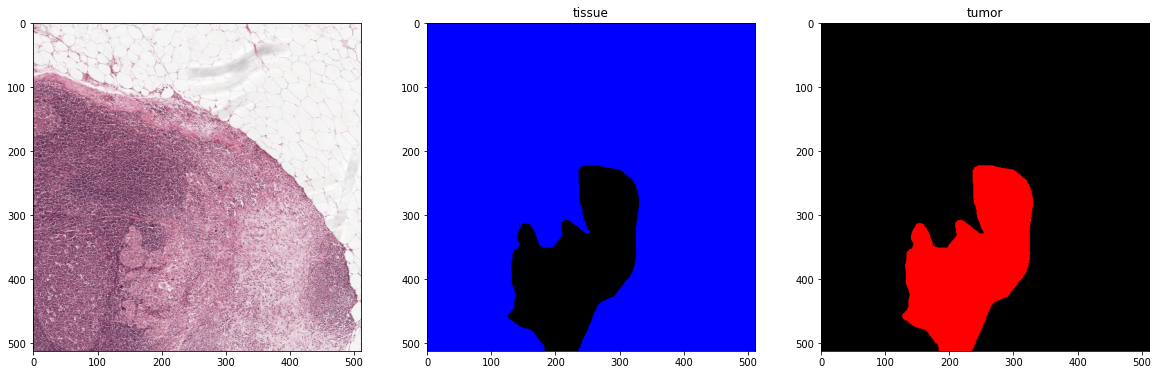

Second batch


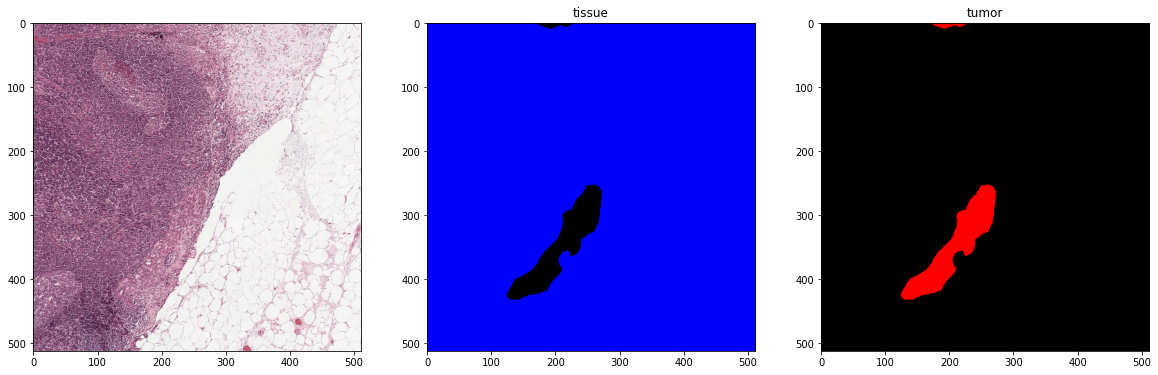

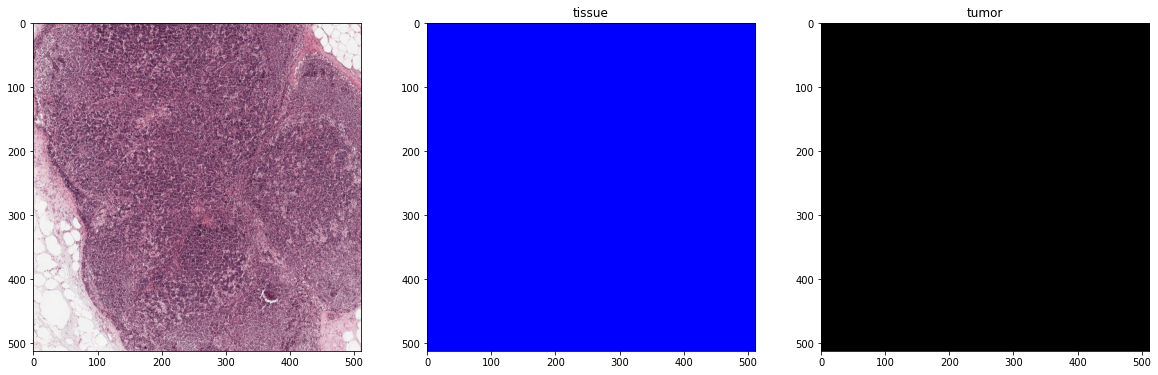

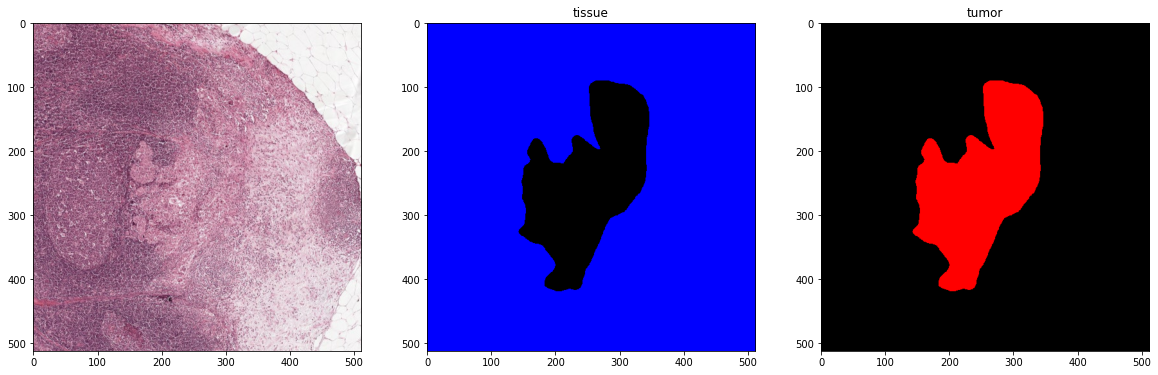

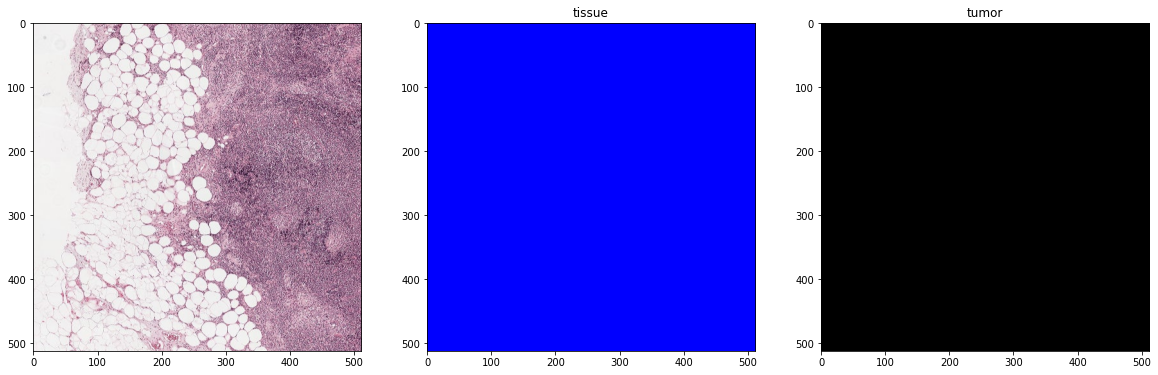

In [6]:

with create_batch_iterator(user_config=user_config, 
                            mode=mode) as training_batch_generator:
    
    color_map = {0: tuple(c*255 for c in Color('blue').rgb), 
                 1: tuple(c*255 for c in Color('red').rgb)}
    
    label_value_map = training_batch_generator.dataset.sample_labels.value_map
    
    print('First batch')
    x_batch, y_batch, info =  next(training_batch_generator)
    plot_one_hot_batch(x_batch, y_batch, color_map=color_map, label_value_map=label_value_map)
    
    print('Second batch')
    x_batch, y_batch, info =  next(training_batch_generator)
    plot_one_hot_batch(x_batch, y_batch, color_map=color_map, label_value_map=label_value_map)